# Importing Essential Libraries

In [2]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image as pil
np.random.seed(123) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

In [3]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K

# LOADING CSV DATA SET 

In [4]:
datacsv=pd.read_csv('data.csv')

In [5]:
datacsv.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
datacsv.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


# DATA INFO
TOTAL 10015 IMAGE.

In [7]:
datacsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


# DATA CLEANING

In [8]:
datacsv.isnull()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
10010,False,False,False,False,False,False,False
10011,False,False,False,False,False,False,False
10012,False,False,False,False,False,False,False
10013,False,False,False,False,False,False,False


# DATA VISUALIZATION

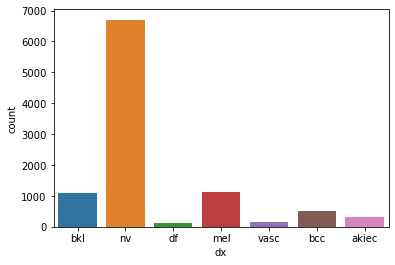

In [9]:
sns. countplot(datacsv["dx"])
# dx is here types of cancer in data set

In [10]:
datacsv["dx"].value_counts()
# number of data with respective cancer

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

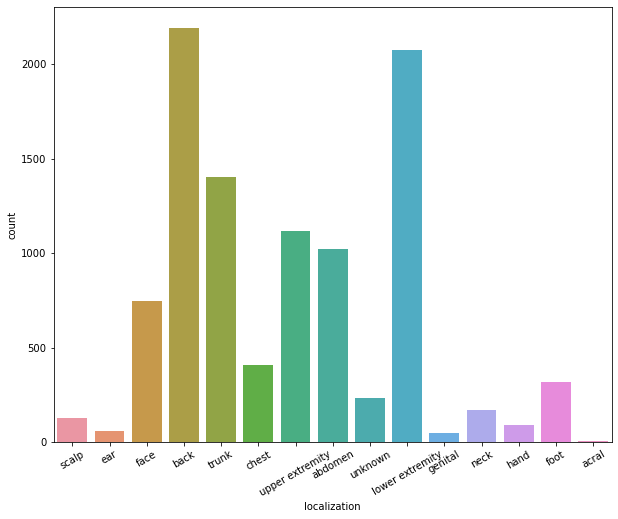

In [11]:
# showing the data visualization where body part most affected by cancer
plt. figure(figsize=(10,8))
sns.countplot(datacsv[ "localization"])
plt.xticks(rotation=30)

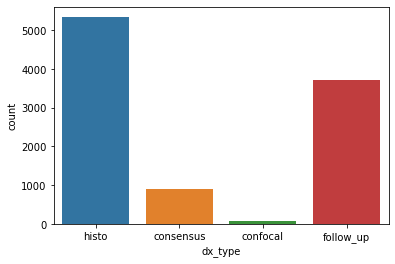

In [12]:
sns.countplot(datacsv["dx_type"])

In [13]:
datacsv["dx_type"].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [14]:
datacsv.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

# filling the NA values with mean

In [15]:
print(datacsv['age'].mean())
print(datacsv['age'].median())
datacsv['age'].fillna(datacsv['age'].mean(), inplace=True)

51.863828077927295
50.0


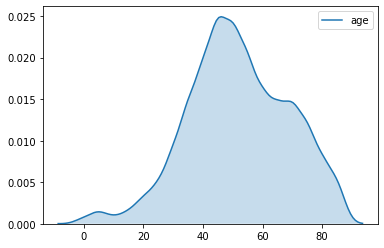

In [16]:
sns.kdeplot (datacsv[ 'age' ],shade=True)

In [17]:
datacsv['sex'].value_counts()
# gender count

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

# creating dic. with respect to all type of cancer,assign the int value

In [18]:
lesion_type_dict ={
    'nv':'melanocytic nevi',
    'mel': 'melanoma',
    'bkl':'benign keratosis-like lesions',
    'bcc':'basal cell carcinoma',
    'akiec':'Actinic keratoses',
    'vasc':'vascular lesions',
    'df':'Dermatofibroma'
}
lesion_classes_dict={
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}
datacsv['cell_type']=datacsv['dx'].map(lesion_type_dict)

In [19]:
datacsv['cell_type_idx'] = pd.Categorical(datacsv['cell_type']).codes

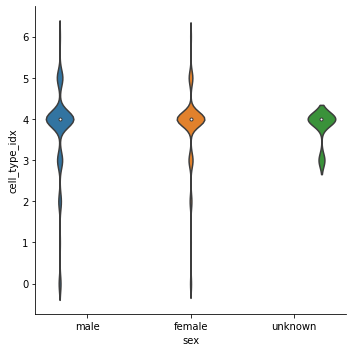

In [20]:
sns.catplot(x="sex",y="cell_type_idx",hue="sex",data=datacsv,kind="violin")

# connecting the IMAGE DATA with CSV DATA FILE

In [21]:
image_path={os.path.splitext(os.path.basename(x))[0]:x
           for x in glob(os.path.join('','*','*.jpg'))}

In [23]:
print(image_path)

SyntaxError: unexpected EOF while parsing (<ipython-input-23-3a0287c34199>, line 1)

In [24]:
datacsv['path']=datacsv['image_id'].map(image_path.get)
datacsv.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,benign keratosis-like lesions,3,train\ISIC_0031633.jpg


In [25]:
datacsv.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,train\ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,train\ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,Actinic keratoses,0,train\ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,Actinic keratoses,0,train\ISIC_0032854.jpg
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,melanoma,5,train\ISIC_0032258.jpg


In [26]:
image_example = np.asarray(pil.open(datacsv['path'][0]))

In [27]:
image_example.shape

(450, 600, 3)

In [71]:

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

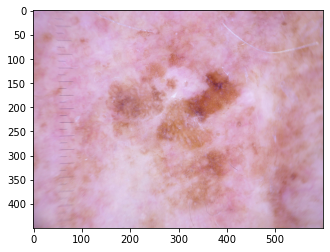

In [72]:
plt.imshow(image_example)

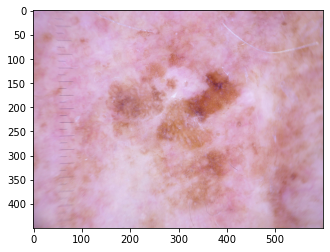

In [73]:
plt.imshow(image_example)


# RESIZE THE IMAGE DATA

In [74]:
datacsv['image'] = datacsv['path'].map(lambda x: np.asarray(pil.open(x) .resize((224,224))))
datacsv.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0027419.jpg,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0025030.jpg,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0026769.jpg,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,benign keratosis-like lesions,3,test\ISIC_0025661.jpg,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,benign keratosis-like lesions,3,train\ISIC_0031633.jpg,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


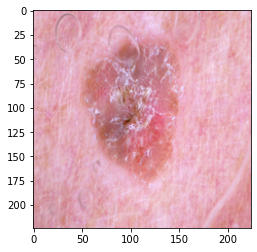

In [75]:
plt.imshow(datacsv['image'][9]) #resized image look like

In [76]:
print(datacsv.shape)

(10015, 11)


# image data set size

In [77]:
#total data shape
datacsv['image'].shape

(10015,)

In [78]:
datacsv['image'][1].shape
#particular image data size

(224, 224, 3)

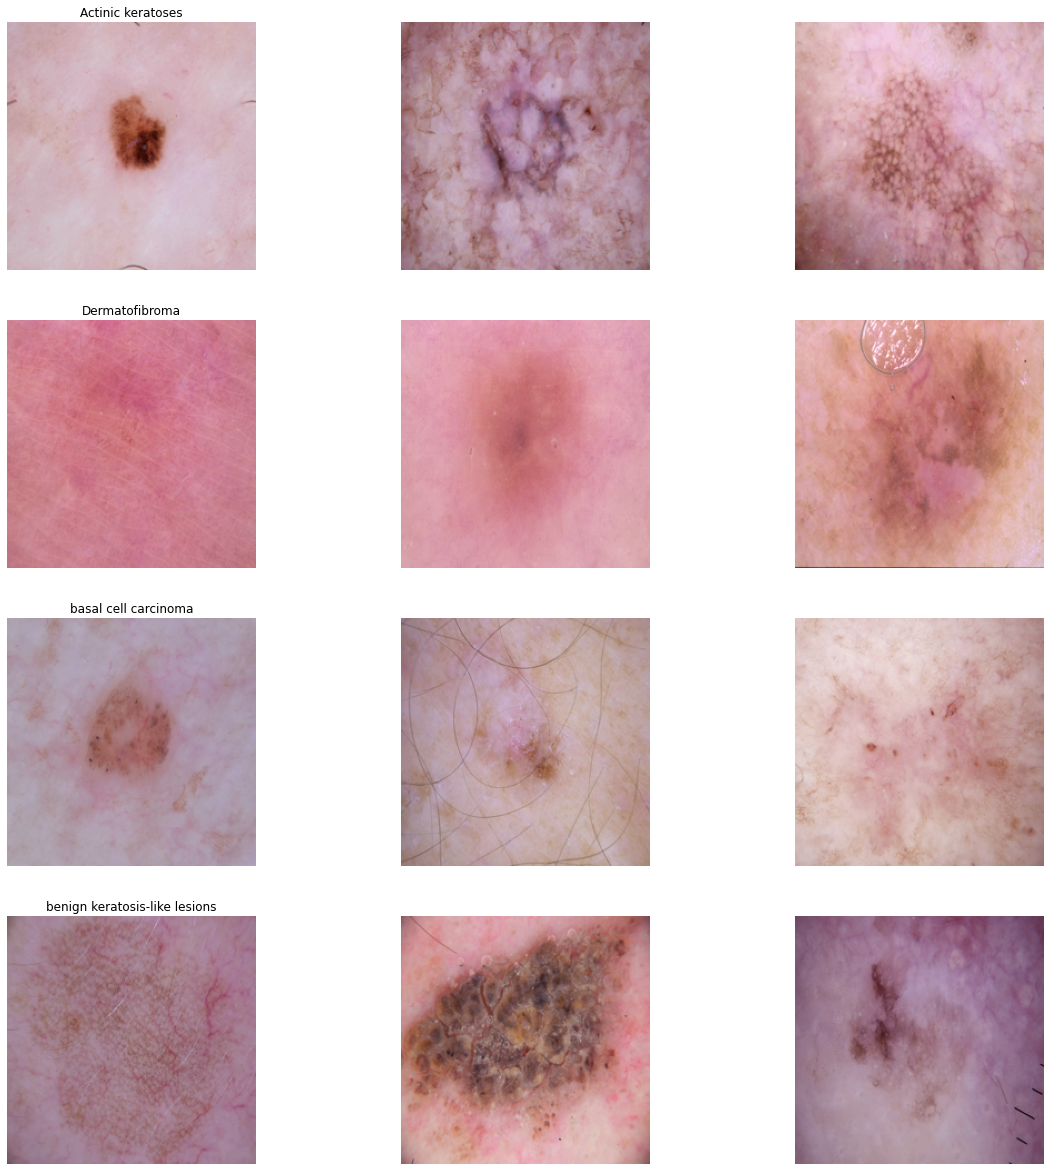

In [79]:
fig,axes = plt.subplots(4,3,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,datacsv.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])
        column_axis.axis('off')

In [80]:
features = datacsv.drop(["cell_type_idx"],axis=1)

target=datacsv["cell_type_idx"]



# spliting into train test   

In [81]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features, target, test_size=0.01)

In [82]:
#converting 
x_train = np.asarray(X_TRAIN[ 'image' ].tolist())
x_test = np.asarray(X_TEST['image' ].tolist())

# size of train test data set

In [83]:
print(x_train.shape)


(9914, 224, 224, 3)


In [84]:
print(x_test.shape)

(101, 224, 224, 3)


In [ ]:
x_train_mean=np.mean(x_train)
x_train_std=np.std(x_train)

x_test_mean=np.mean(x_train)
x_test_std=np.std(x_train)

x_train=(x_train-x_train_mean)/x_train_std
x_test=(x_test-x_test_mean)/x_test_std

In [ ]:
print(Y_TRAIN.shape)

In [ ]:
print(Y_TEST.shape)

In [ ]:
y_train=to_categorical(Y_TRAIN,num_classes=7)
y_test=to_categorical(Y_TEST,num_classes=7)

In [ ]:
print(y_train.shape)

In [ ]:
print(y_test.shape)

In [ ]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train, test_size=0.15)

In [ ]:
print(X_train.shape)

In [ ]:
X_train=X_train.reshape(X_train.shape[0],90,124,3)
x_test=x_test.reshape(x_test.shape[0],90,124,3)
X_val=X_val.reshape(X_val.shape[0],90,124,3)

In [ ]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

# cnn model 

In [90]:
input_shape = (90,124,3)
num_classes= 7

model = Sequential ()

model. add(Conv2D(37, kernel_size=(3,3),activation='relu' ,padding = 'Same' , input_shape=input_shape))
model .add(Conv2D(32,kernel_size=(3,3), activation='relu',padding = 'same'))
model. add(MaxPool2D(pool_size=(2,2)))
model. add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model. add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model. add(MaxPool2D(pool_size = (2, 2)))
model. add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model. add(Dropout(0.5))
model. add(Dense(num_classes, activation='softmax'))
model. summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 90, 124, 37)       1036      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 124, 32)       10688     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 31, 64)       

# new methode

In [ ]:
model.compile(optimizer = 'adam',loss = "categorical_crossentropy",metrics=["accuracy"])

In [ ]:
model.compile(optimizer = 'adam',loss = "categorical_crossentropy",metrics=["accuracy"])

In [91]:
# COMPILE THE MODEL
model.compile(optimizer = 'adam',loss = "categorical_crossentropy",metrics=["accuracy"])

In [92]:
model.compile(optimizer = 'adam',loss = "categorical_crossentropy",metrics=["accuracy"])

In [93]:
# with data augmentation to prevent overfitting
datagen= ImageDataGenerator(rotation_range=10,
                           zoom_range=0.1)

# fit the model

In [98]:
# finaly fit the model
epochs=51
batch_size=30
model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),epochs=epochs,validation_data=(X_val,Y_val),
                   verbose=1,steps_per_epoch=X_train.shape[0]/batch_size,
                   callbacks=[learning_rate_reduction])

C:\Users\Nitin\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/51
313/313 [==============================] - 232s 738ms/step - loss: 1.1995 - accuracy: 0.6513 - val_loss: 0.8046 - val_accuracy: 0.7097
Epoch 2/51
313/313 [==============================] - 235s 751ms/step - loss: 0.8918 - accuracy: 0.6783 - val_loss: 0.7771 - val_accuracy: 0.7157
Epoch 3/51
313/313 [==============================] - 237s 756ms/step - loss: 0.8389 - accuracy: 0.6944 - val_loss: 0.7137 - val_accuracy: 0.7177
Epoch 4/51
313/313 [==============================] - 233s 745ms/step - loss: 0.8293 - accuracy: 0.6944 - val_loss: 0.6672 - val_accuracy: 0.7339
Epoch 5/51
313/313 [==============================] - 232s 742ms/step - loss: 0.8027 - accuracy: 0.6994 - val_loss: 0.6579 - val_accuracy: 0.7520
Epoch 6/51
313/313 [==============================] - 234s 746ms/step - loss: 0.7722 - accuracy: 0.7174 - val_loss: 0.6621 - val_accuracy: 0.7581
Epoch 7/51
313/313 [==============================] - 230s 736ms/step - loss: 0.7369 - accuracy: 0.7272 - val_loss: 0.6523 -

#